In [1]:
%pip install numpy==1.26.4
%pip install pandas==2.1.4
%pip install seaborn==0.13.2
%pip install pingouin


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Questionnaire

As part of the quantitative analysis, the data from the questionnaire is evaluated to assess the impact of the pre-consent mechanism on user experience, specifically in terms of acceptance and usability. Quantifiable questions are analyzed statistically in this notebook, while free-text responses are summarized and interpreted as part of the broader master’s thesis. 

Except for the section on inferential statistics, the analysis presented here focuses on descriptive statistics to provide an overview of the collected data and identify patterns in participant responses.

In [2]:
import os
import glob
import re

import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML, Markdown

sns.set_theme()

# Adjust Pandas display options to ensure full-width display
pd.set_option('display.max_colwidth', None)  # No limit on column width
pd.set_option('display.expand_frame_repr', False)  # Disable truncation of wide DataFrames
pd.set_option('display.max_rows', None)  # Show all rows if necessary

## Data Source

The responses file of the participants is loaded from a CSV file and stored in a DataFrame for further analysis.

In [3]:
file_path = "data/results-survey393144.csv"

# Load responses into a DataFrame
raw_df = pd.read_csv(file_path)

# Recoding Column Names


# Display the first few rows to verify
raw_df.head()

,Antwort ID,Datum Abgeschickt,Letzte Seite,Start-Sprache,Zufallsstartwert,Datum gestartet,Datum letzte Aktivität,Bitte geben Sie Ihr Geschlecht an.,Bitte geben Sie Ihr Alter in Jahren an.,Bitte geben Sie Ihre Gruppenzugehörigkeit an.,...,"Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an. [Ich finde, dass die verschiedenen Funktionen des Systems gut integriert sind.]","Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an. [Ich kann mir vorstellen, dass die meisten Leute das System schnell zu beherrschen lernen.]",Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an. [Ich habe mich bei der Nutzung des Systems sehr sicher gefühlt.],Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an. [Ich empfinde die Bedienung als sehr umständlich.],Welches der beiden Systeme würden Sie bevorzugen?,Wie bewerten Sie den Pre-Consent-Mechanismus in Bezug auf seine Funktionalität und Benutzerfreundlichkeit?,Inwieweit würden sie dem gezeigten Pre-Consent Mechanismus vertrauen?,Haben Sie Verbesserungsvorschläge?,Haben Sie Bedenken hinsichtlich der Nutzung des Pre-Consent Mechanismus?,"Gibt es etwas, das Sie uns gerne noch mitteilen möchten?(z.B. Anregungen, Ideen, Kritik oder Feedback)"
0,10,2024-11-27 13:54:16,8,de,1367034576,2024-11-27 13:42:04,2024-11-27 13:54:16,Männlich,24,Studierende,...,Trifft eher zu,Trifft vollständig zu,Trifft vollständig zu,Trifft gar nicht zu,App mit Pre-Consent,Sehr gut,Eher Vertrauen,"beim preconsent klarer darstellen für welche entität er gilt, \nbeim anzeigen von datenübertragung mit preconsent nochtmals auflisten welche daten übertragen wurden.\ndaten direkt zeigen: kein Name, Vorname sondern den namen ausschreiben. zb Simon Lund, Student..",wenn mir nochmal gezeigt wird weelche daten übertragen wurden find ichs fair,history und erstmalige nutzung von consent usw.
1,11,2024-11-27 15:44:19,8,de,764710841,2024-11-27 15:20:20,2024-11-27 15:44:19,Männlich,40,Mitarbeiter,...,Trifft vollständig zu,Trifft eher zu,Trifft vollständig zu,Trifft gar nicht zu,App mit Pre-Consent,Gut,Eher Vertrauen,"Bei größeren Schlangen oder anderen stressigen Situationen (z.B. Mensa) wäre es gut, wenn man an einem separat stehenden Terminal einmal in Ruhe die Abgefragten Felder durchgehen kann. Anschließesn greift der Pre-Consent",Eine einmalig unbedachte Zustimmung wirkt sich langfristig aus. Initiale zustimmung sollte nicht gehetzt erfolgen.\nAnsonsten nein.,NaN
2,12,2024-11-27 19:34:27,8,de,1951665246,2024-11-27 19:16:13,2024-11-27 19:34:27,Weiblich,25,Studierende,...,Trifft eher zu,Trifft vollständig zu,Trifft eher zu,Trifft gar nicht zu,App mit Pre-Consent,Gut,Eher Vertrauen,NaN,"Wenn man den Pre-Consent updatet, weil an verschiedenen Stellen der gleiche Betreiber verwendet wird, man aber nicht alle Infos automatisch immer mit allen Stellen des Betreibers teilen will und sich dessen nicht bewusst ist, dass es passieren kann.",NaN
3,13,2024-11-27 22:00:03,8,de,1918662232,2024-11-27 21:29:37,2024-11-27 22:00:03,Männlich,27,Studierende,...,Trifft eher zu,Trifft vollständig zu,Trifft vollständig zu,Trifft gar nicht zu,App mit Pre-Consent,Gut,Voll Vertrauen,"Die Sprache sollte auf deutsch umstellbar sein.\nWenn Expiry Date (oder alle Felder) könnten auch im Prozess den aktuellen Wert anzeigen, um mich zu erinnern.\nPre-consents sollten auch Feld-weise und nicht nur Verifizierer-weise löschbar sein.\nAuch bei eingestelltem pre-consent können zusammen mit dem grünen Haken die übertragenen Felder kurz angezeigt werden.","Ich finde, der pre-consent sollte unabhängig von der Nutzung eine lifetime von ca. 60 Tagen haben. Alle 60 Tage muss ich also ihn erneut erteilen.","Der Zweck (ID, Studistatus, Alter, etc.) sollte mit dastehen. (In echt habe ich ja keinen Wochenplan, wo es steht.)"
4,14,2024-11-28 12:45:05,8,de,1029479343,2024-11-28 12:30:26,2024-11-28 12:45:05,Männlich,22,Studierende,...,Trifft eher zu,Trifft eher zu,Trifft eher zu,Trifft gar nicht zu,App mit Pre-Consent,Gut,Eher Vertra

## Recoding Headers

In this step, the original column names in the responses DataFrame are replaced with simpler labels that correspond to the data's meaning. This helps improve readability and ensures that the columns are properly identified in later analysis. Below is the mapping between the original column names and the new descriptive labels:

In [4]:
# Define the new column labels
column_labels = [
    "Response_ID", "Date_Submitted", "Last_Page", "Start_Language", "Random_Start_Value",
    "Date_Started", "Date_Last_Activity", "Gender", "Age", "Group",
    "TechAffinity_01", "TechAffinity_02", "TechAffinity_03", "TechAffinity_04",
    "TechAffinity_05", "TechAffinity_06", "TechAffinity_07", "TechAffinity_08",
    "TechAffinity_09", "Data_Protection", "NoPC_01", "NoPC_02", "NoPC_03", "NoPC_04", "NoPC_05",
    "NoPC_Verifier", "NoPC_Verifier_Open", "NoPC_Question_WeeklyPlan", "NoPC_Transaction",
    "NoPC_Transaction_Open", "PC_01", "PC_02", "PC_03", "PC_04", "PC_05",
    "PC_Verifier", "PC_Verifier_Open", "PC_Question_WeeklyPlan", "PC_Transaction",
    "PC_Transaction_Open", 
    # Questions encoded as in original SUS (see section on SUS below for more details) 
    #   - questions 6 and 10 are missing
    #   - questions 8 and 9 were switched up in the questionnaire 
    "PC_SUS_01", "PC_SUS_02", "PC_SUS_03", "PC_SUS_04", "PC_SUS_05", "PC_SUS_07", "PC_SUS_09", "PC_SUS_08", 
    "System_Preference", "PreConsent_Usability", "PreConsent_Trust", "PreConsent_Improvement", "PreConsent_Concerns", "Feedback"
]

# Create a mapping DataFrame
mapping_df = pd.DataFrame({
    "Abbreviated Label": column_labels,              
    "Original Label": raw_df.columns.tolist()
})

# Display the mapping
display(mapping_df.style.set_properties(**{'text-align': 'left'}))

# Save column mapping as csv
mapping_df.to_csv('column_mapping.csv', index=False)


def get_original_label(abbreviation, subquestion_only=False):
    """
    Retrieve the original question label corresponding to an abbreviated column name.

    :param abbreviation: The abbreviated column name (e.g., 'NoPC_01', 'PC_01').
    :param subquestion_only: If True, extract and return only the text within brackets 
                              (e.g., '[Subquestion]') from the original label.
    :return: The original question label or subquestion as a string, depending on the value of subquestion_only.
    """
    original_label = mapping_df.loc[mapping_df['Abbreviated Label'] == abbreviation, 'Original Label'].values[0]

    if subquestion_only:
        return re.search(r'\[(.*?)\]', original_label).group(1)
        
    return original_label

,Abbreviated Label,Original Label
0,Response_ID,Antwort ID
1,Date_Submitted,Datum Abgeschickt
2,Last_Page,Letzte Seite
3,Start_Language,Start-Sprache
4,Random_Start_Value,Zufallsstartwert
5,Date_Started,Datum gestartet
6,Date_Last_Activity,Datum letzte Aktivität
7,Gender,Bitte geben Sie Ihr Geschlecht an.
8,Age,Bitte geben Sie Ihr Alter in Jahren an.
9,Group,Bitte geben Sie Ihre Gruppenzugehörigkeit an.


In [5]:
# Recode the column names
df = raw_df.copy()
df.columns = column_labels

# Display the first few rows to verify
df.head()

,Response_ID,Date_Submitted,Last_Page,Start_Language,Random_Start_Value,Date_Started,Date_Last_Activity,Gender,Age,Group,...,PC_SUS_05,PC_SUS_07,PC_SUS_09,PC_SUS_08,System_Preference,PreConsent_Usability,PreConsent_Trust,PreConsent_Improvement,PreConsent_Concerns,Feedback
0,10,2024-11-27 13:54:16,8,de,1367034576,2024-11-27 13:42:04,2024-11-27 13:54:16,Männlich,24,Studierende,...,Trifft eher zu,Trifft vollständig zu,Trifft vollständig zu,Trifft gar nicht zu,App mit Pre-Consent,Sehr gut,Eher Vertrauen,"beim preconsent klarer darstellen für welche entität er gilt, \nbeim anzeigen von datenübertragung mit preconsent nochtmals auflisten welche daten übertragen wurden.\ndaten direkt zeigen: kein Name, Vorname sondern den namen ausschreiben. zb Simon Lund, Student..",wenn mir nochmal gezeigt wird weelche daten übertragen wurden find ichs fair,history und erstmalige nutzung von consent usw.
1,11,2024-11-27 15:44:19,8,de,764710841,2024-11-27 15:20:20,2024-11-27 15:44:19,Männlich,40,Mitarbeiter,...,Trifft vollständig zu,Trifft eher zu,Trifft vollständig zu,Trifft gar nicht zu,App mit Pre-Consent,Gut,Eher Vertrauen,"Bei größeren Schlangen oder anderen stressigen Situationen (z.B. Mensa) wäre es gut, wenn man an einem separat stehenden Terminal einmal in Ruhe die Abgefragten Felder durchgehen kann. Anschließesn greift der Pre-Consent",Eine einmalig unbedachte Zustimmung wirkt sich langfristig aus. Initiale zustimmung sollte nicht gehetzt erfolgen.\nAnsonsten nein.,NaN
2,12,2024-11-27 19:34:27,8,de,1951665246,2024-11-27 19:16:13,2024-11-27 19:34:27,Weiblich,25,Studierende,...,Trifft eher zu,Trifft vollständig zu,Trifft eher zu,Trifft gar nicht zu,App mit Pre-Consent,Gut,Eher Vertrauen,NaN,"Wenn man den Pre-Consent updatet, weil an verschiedenen Stellen der gleiche Betreiber verwendet wird, man aber nicht alle Infos automatisch immer mit allen Stellen des Betreibers teilen will und sich dessen nicht bewusst ist, dass es passieren kann.",NaN
3,13,2024-11-27 22:00:03,8,de,1918662232,2024-11-27 21:29:37,2024-11-27 22:00:03,Männlich,27,Studierende,...,Trifft eher zu,Trifft vollständig zu,Trifft vollständig zu,Trifft gar nicht zu,App mit Pre-Consent,Gut,Voll Vertrauen,"Die Sprache sollte auf deutsch umstellbar sein.\nWenn Expiry Date (oder alle Felder) könnten auch im Prozess den aktuellen Wert anzeigen, um mich zu erinnern.\nPre-consents sollten auch Feld-weise und nicht nur Verifizierer-weise löschbar sein.\nAuch bei eingestelltem pre-consent können zusammen mit dem grünen Haken die übertragenen Felder kurz angezeigt werden.","Ich finde, der pre-consent sollte unabhängig von der Nutzung eine lifetime von ca. 60 Tagen haben. Alle 60 Tage muss ich also ihn erneut erteilen.","Der Zweck (ID, Studistatus, Alter, etc.) sollte mit dastehen. (In echt habe ich ja keinen Wochenplan, wo es steht.)"
4,14,2024-11-28 12:45:05,8,de,1029479343,2024-11-28 12:30:26,2024-11-28 12:45:05,Männlich,22,Studierende,...,Trifft eher zu,Trifft eher zu,Trifft eher zu,Trifft gar nicht zu,App mit Pre-Consent,Gut,Eher Vertrauen,"Aufklärung über die Tatsache, dass bei neuen Datenattributen erneut eine pre consent abfrage für diesen Datentyp abgefragt wird; Möglichkeit zum widerruf des pre consents","als nutzer könnte man auf dauer vergessen, welche Daten dort gerade geteilt werden",NaN


## Demographic Characteristics

This section provides an overview of the participants' demographic characteristics, including age, gender, and group affiliation (student/employee). The data is presented in tables showing the total number of participants for each category, along with the corresponding percentages. This allows for a clear understanding of the composition of the participant group and their distribution across these key demographic variables.

In [6]:
# Calculate the mean age by group
mean_age_by_group = df.groupby('Group')['Age'].mean().round(2)

# Convert to a DataFrame for better display
mean_age_table = mean_age_by_group.reset_index()
mean_age_table.columns = ['Group', 'Mean Age']

# Display the table with a caption
display(Markdown("### Mean Age by Group"))
display(mean_age_table)

### Mean Age by Group

,Group,Mean Age
0,Mitarbeiter,41.00
1,Studierende,24.36


In [7]:
# Gender Table (Geschlecht)
gender_table = pd.DataFrame({
    'Total': df['Gender'].value_counts(),
    'Percentage (%)': df['Gender'].value_counts(normalize=True) * 100
}).round(2)

# Display Gender Table
display(Markdown("### Gender Distribution"))
display(gender_table)

### Gender Distribution

,Total,Percentage (%)
Gender,,
Männlich,12,80.00
Weiblich,2,13.33
Divers,1,6.67


In [8]:
# Group Affiliation Table (Gruppe)
group_table = pd.DataFrame({
    'Total': df['Group'].value_counts(),
    'Percentage (%)': df['Group'].value_counts(normalize=True) * 100
}).round(2)

# Display Group Affiliation Table
display(Markdown("### Group Affiliation Distribution"))
display(group_table)

### Group Affiliation Distribution

,Total,Percentage (%)
Group,,
Studierende,11,73.33
Mitarbeiter,4,26.67


## ATI Scale

The **Affinity for Technology Interaction (ATI)** scale measures an individual's tendency to engage with and feel comfortable using technology. It consists of a set of standardized items designed to evaluate attitudes and preferences related to technology interaction. 
Participants respond to each item on a Likert scale, and the overall score represents their level of affinity for interacting with technology. A higher score indicates a stronger inclination toward interacting with technology and a greater level of comfort and confidence in using it.

Cronbach's alpha was calculated to assess the internal consistency of the scale items in this dataset. The alpha coefficient for this sample was 0.89, indicating good reliability.

In [9]:
ati_columns = list(filter(lambda x: x.startswith("TechAffinity_"), column_labels))

ati_original_labels = map(lambda x: get_original_label(x, subquestion_only=True), ati_columns)

# Create a mapping DataFrame
ati_mapping_df = pd.DataFrame({
    "Abbreviated Label": ati_columns,              
    "Original Label": ati_original_labels
}).sort_values(by="Abbreviated Label")

# Display the mapping of abbreviation -> original label 
# This allows users to verifiy question mapping for ATI
display(ati_mapping_df.style.set_properties(**{'text-align': 'left'}))

,Abbreviated Label,Original Label
0,TechAffinity_01,Ich beschäftige mich gern genauer mit technischen Systemen.
1,TechAffinity_02,Ich probiere gern die Funktionen neuer technischer Systeme aus.
2,TechAffinity_03,"In erster Linie beschäftige ich mich mit technischen Systemen, weil ich muss."
3,TechAffinity_04,"Wenn ich ein neues technisches System vor mir habe, probiere ich es intensiv aus."
4,TechAffinity_05,Ich verbringe sehr gern Zeit mit dem Kennenlernen eines neuen technischen Systems.
5,TechAffinity_06,"Es genügt mir, dass ein technisches System funktioniert, mir ist es egal, wie oder warum."
6,TechAffinity_07,"Ich versuche zu verstehen, wie ein technisches System genau funktioniert."
7,TechAffinity_08,"Es genügt mir, die Grundfunktionen eines technischen Systems zu kennen."
8,TechAffinity_09,"Ich versuche, die Möglichkeiten eines technischen Systems vollständig auszunutzen."


### Overall Mean  & SD of ATI Scale

**Mean:** 4.41

**Standard Deviation (SD):** 0.96

**Cronbach's Alpha:** 0.89

### Mean & SD for ATI Scale by Group

,Group,Mean ATI Scale,SD ATI Scale
0,Mitarbeiter,4.444444,0.806353
1,Studierende,4.393939,1.040375


### Distribution of ATI Scale Scores

Text(0, 0.5, 'ATI Scale')

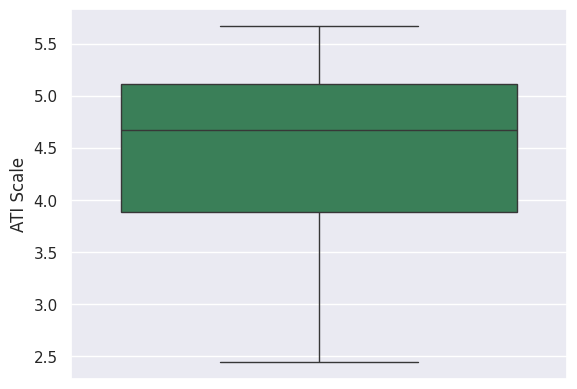

In [10]:
# Mapping for positively scored items
# These items are scored such that higher agreement (e.g., "Stimmt völlig") corresponds to higher values.
ati_response_map_positive = {
    "Stimmt gar nicht": 1,
    "Stimmt weitgehend nicht": 2,
    "Stimmt eher nicht": 3,
    "Stimmt eher": 4,
    "Stimmt weitgehend": 5,
    "Stimmt völlig": 6
}

ati_columns_positive = [
    "TechAffinity_01", "TechAffinity_02",
    "TechAffinity_04", "TechAffinity_05",
    "TechAffinity_07", "TechAffinity_09"
]


# Mapping for negatively scored items
# These items are reverse-coded because higher agreement reflects a lower affinity for technology.
ati_response_map_negative = {
    "Stimmt gar nicht": 6,
    "Stimmt weitgehend nicht": 5,
    "Stimmt eher nicht": 4,
    "Stimmt eher": 3,
    "Stimmt weitgehend": 2,
    "Stimmt völlig": 1
}

ati_columns_negative = [
    "TechAffinity_03", "TechAffinity_06", "TechAffinity_08"
]


# Copy DataFrame for ATI transformations
ati_df = df.copy()

# Recode positive ATI items
# Using the positive mapping for columns where higher agreement corresponds to higher scores
for col in ati_columns_positive:
    ati_df[col] = ati_df[col].map(ati_response_map_positive)

# Recode negative ATI items
# Using the negative mapping for reverse-coded columns
for col in ati_columns_negative:
    ati_df[col] = ati_df[col].map(ati_response_map_negative)

# Calculate ATI scale as the mean of all ATI columns in the new table, excluding missing values
ati_columns = ati_columns_positive + ati_columns_negative
ati_df['ATI_Scale'] = ati_df[ati_columns].mean(axis=1)

# Calculate overall mean, sd of ATI_Scale
overall_mean = ati_df['ATI_Scale'].mean()
overall_sd = ati_df['ATI_Scale'].std()

# Calculate Cronbach's alpha for the ATI items using Pingouin
ati_items = ati_df[ati_columns]  # Only the columns used for the ATI scale
alpha = pg.cronbach_alpha(data=ati_items)

# Display overall ATI_Scale mean, standard deviation and Cronbach's alpha
display(Markdown("### Overall Mean  & SD of ATI Scale"))
display(Markdown(f"**Mean:** {round(overall_mean, 2)}"))
display(Markdown(f"**Standard Deviation (SD):** {round(overall_sd, 2)}"))
display(Markdown(f"**Cronbach's Alpha:** {round(alpha[0], 2)}"))

# Calculate mean and SD of ATI_Scale grouped by 'Group'
ati_group_stats = ati_df.groupby('Group')['ATI_Scale'].agg(['mean', 'std']).reset_index()
ati_group_stats.columns = ['Group', 'Mean ATI Scale', 'SD ATI Scale']

# Display ATI_Scale group means in a table
display(Markdown("### Mean & SD for ATI Scale by Group"))
display(ati_group_stats)

# Plot data
display(Markdown("### Distribution of ATI Scale Scores"))
ax = sns.boxplot(
    y=ati_df['ATI_Scale'],
    color='seagreen'
)

ax.set_ylabel("ATI Scale")

## Data Protection  

This section evaluates the importance participants place on the protection of personal data in the digital realm, based on their response to a single question. The results offer a straightforward insight into how participants prioritize data privacy in their interactions with digital systems.  

Participants rated their agreement on a scale ranging from *"Disagree"* to *"Fully Agree"*.  

In [11]:
response_order = {
        "Stimme nicht zu": 5,
        "Stimmer eher nicht zu": 4,
        "Stimme teilweise zu": 3,
        "Stimmer eher zu": 2,
        "Stimme voll zu": 1
}

# Calculate totals and percentages for "Datenschutz"
data_protection_df = pd.DataFrame({
    "Total": df['Data_Protection'].value_counts(),
    "Percentage (%)": df['Data_Protection'].value_counts(normalize=True) * 100
}).round(2)

# Sort by response_order
data_protection_df2 = data_protection_df.sort_values(
    by="Data_Protection",
    key=lambda series: series.map(response_order)
)

# Display the table
display(Markdown(f"### Sense of Privacy \n **Original Question**: {get_original_label('Data_Protection')}"))
display(data_protection_df2)

### Sense of Privacy 
 **Original Question**: Mir ist der Schutz meiner persönlichen Daten im digitalen Raum ein wichtiges Anliegen. 

,Total,Percentage (%)
Data_Protection,,
Stimme voll zu,6,40.00
Stimmer eher zu,7,46.67
Stimmer eher nicht zu,2,13.33


## Ad hoc Questions

This section focuses on five targeted questions designed to assess specific aspects of user experience for both system variants: with and without pre-consent. These questions aim to evaluate:

- user perceptions of the information presented,
- the cognitive load required to complete tasks,
- the clarity of the information,
- whether the repetition of informed consent was perceived as disruptive, and
- whether the process of informed consent was considered too lengthy overall.

However, question 4 was incorrectly phrased in the questionnaire. The original phrasing was: _"I found the repetition of informed consent too long."._ Participants were informed of this error and were read the correct question: _"I found the consent process per transaction too long."_

By asking these questions for both variants, a direct comparison of user experiences is facilitated. The results are displayed in a table format for clarity.


In [12]:
# Order for the response labels
response_order = [
    "Stimmt völlig",
    "Stimmt weitgehend",
    "Stimmt eher",
    "Stimmt eher nicht",
    "Stimmt weitgehend nicht",    
    "Stimmt gar nicht",
]

for i in range(1,6):
    qid = str(i).zfill(2)
    nopc_id = f"NoPC_{qid}"
    pc_id = f"PC_{qid}"

    # Calculate totals and percentages for questions
    adhoc_df = pd.DataFrame({
        "Without Pre-Consent": df[nopc_id].value_counts().astype('Int64'),
        "Without Pre-Consent (%)": df[nopc_id].value_counts(normalize=True) * 100,
        "With Pre-Consent": df[pc_id].value_counts().astype('Int64'),
        "With Pre-Consent (%)": df[pc_id].value_counts(normalize=True) * 100,
    }).round(2).reindex(response_order).fillna(0)

    original_question = get_original_label(nopc_id, subquestion_only=True)

    display(Markdown(f"### Question {i}: {original_question}"))
    display(adhoc_df)

### Question 1: Ich fand die Menge an Informationen überfordernd.

,Without Pre-Consent,Without Pre-Consent (%),With Pre-Consent,With Pre-Consent (%)
Stimmt völlig,0,0.00,0,0.00
Stimmt weitgehend,0,0.00,0,0.00
Stimmt eher,1,6.67,1,6.67
Stimmt eher nicht,4,26.67,3,20.00
Stimmt weitgehend nicht,3,20.00,4,26.67
Stimmt gar nicht,7,46.67,7,46.67


### Question 2: Ich fand die angezeigten Informationen verständlich.

,Without Pre-Consent,Without Pre-Consent (%),With Pre-Consent,With Pre-Consent (%)
Stimmt völlig,8,53.33,5,33.33
Stimmt weitgehend,6,40.00,10,66.67
Stimmt eher,1,6.67,0,0.00
Stimmt eher nicht,0,0.00,0,0.00
Stimmt weitgehend nicht,0,0.00,0,0.00
Stimmt gar nicht,0,0.00,0,0.00


### Question 3: Die Wiederholung der informierten Zustimmung hat mich gestört.

,Without Pre-Consent,Without Pre-Consent (%),With Pre-Consent,With Pre-Consent (%)
Stimmt völlig,3,20.00,1,6.67
Stimmt weitgehend,4,26.67,0,0.00
Stimmt eher,1,6.67,1,6.67
Stimmt eher nicht,2,13.33,2,13.33
Stimmt weitgehend nicht,4,26.67,6,40.00
Stimmt gar nicht,1,6.67,5,33.33


### Question 4: Die Wiederholung der informierten Zustimmung empfand ich als zu lang.

,Without Pre-Consent,Without Pre-Consent (%),With Pre-Consent,With Pre-Consent (%)
Stimmt völlig,3,20.00,0,0.00
Stimmt weitgehend,2,13.33,1,6.67
Stimmt eher,2,13.33,1,6.67
Stimmt eher nicht,2,13.33,5,33.33
Stimmt weitgehend nicht,3,20.00,5,33.33
Stimmt gar nicht,3,20.00,3,20.00


### Question 5: Das Erledigen der Aufgabe hat meine Konzentration beansprucht.

,Without Pre-Consent,Without Pre-Consent (%),With Pre-Consent,With Pre-Consent (%)
Stimmt völlig,0,0.00,0,0.00
Stimmt weitgehend,2,13.33,2,13.33
Stimmt eher,4,26.67,1,6.67
Stimmt eher nicht,1,6.67,4,26.67
Stimmt weitgehend nicht,4,26.67,3,20.00
Stimmt gar nicht,4,26.67,5,33.33


## Verifier and Transactions

In the questionnaire, participants were asked two Yes/No/Don’t Know questions related to verifiers and transactions. Specifically, they were asked whether they noticed different verifiers and whether they were surprised by the request for certain data fields during transactions.

If participants answered Yes to these questions, they were asked to list the verifiers, transactions, and data fields they observed. The analysis focuses on the Yes responses to determine how many participants actively noticed verifiers or unexpected data requests. Additionally, the free-text responses provided by participants are analyzed to gain further insights into their experiences and observations.

This approach combines quantitative data with qualitative feedback to provide a more comprehensive understanding of user awareness and interaction with verifiers and transactions in the system.

In [13]:
# Noticed Different Verifiers? (yes/no/don't know)
verifier_df = pd.DataFrame({
    "Without Pre-Consent": df["NoPC_Verifier"].value_counts().astype('Int64'),
    "Without Pre-Consent (%)": df["NoPC_Verifier"].value_counts(normalize=True) * 100,
    "With Pre-Consent": df["PC_Verifier"].value_counts().astype('Int64'),
    "With Pre-Consent (%)": df["PC_Verifier"].value_counts(normalize=True) * 100,
}).round(2).fillna(0)

display(Markdown("### Responses: Noticed Different Verifiers"))
display(verifier_df)

# Free-text responses for 'Yes'
verifier_yes_text_nopc = df.loc[df["NoPC_Verifier"] == "Ja", "NoPC_Verifier_Open"]
verifier_yes_text_pc = df.loc[df["PC_Verifier"] == "Ja", "PC_Verifier_Open"]

# Combine free-text responses into a single DataFrame for display
verifier_free_text_df = pd.DataFrame({
    "Without Pre-Consent": verifier_yes_text_nopc.reset_index(drop=True),
    "With Pre-Consent": verifier_yes_text_pc.reset_index(drop=True)
})

display(Markdown("### Free-Text Responses: Noticed Verifiers (Participants who answered 'Yes')"))
display(verifier_free_text_df.style.set_properties(**{'text-align': 'left'}))

### Responses: Noticed Different Verifiers

,Without Pre-Consent,Without Pre-Consent (%),With Pre-Consent,With Pre-Consent (%)
Ja,15,100.0,15,100.0


### Free-Text Responses: Noticed Verifiers (Participants who answered 'Yes')

,Without Pre-Consent,With Pre-Consent
0,"LMU, Seat iwas","LMU, Seat..."
1,"LMU Seite (Betriebsarzt, IT-Servicedesk, ...) Rabattierung (Studentenwerk, Oper, Messe, ...) ÖPNV (Fahrscheinkontrolle)","LMU Intern (Pforte, ...) Rabattierung (Studierendenwerk, Ausstellung) ÖPNV (Fahrscheinkontrolle)"
2,"LMU, Studierendenwerk, MVG, SeatLover GmBH (oder so)","MVG, LMU, SeatLovers (oder so), Studierendenwerk"
3,LMU Reader MVG Save Seat GmbH,LMU Reader MVG Save Seat GmbH
4,"Universtät, Studentenwerk, Konzertbetreiber, Clubbetreiber, Fahrscheinkontrolle",Die gleichen in der anderen App-Variante
5,"Uni, Fahrscheinkontrolle, Museum, Konzert, Messe, Ausstellung","Uni, Fahrscheinkontrolle, Kino, Club, Museum"
6,"mvg,lmu,studentenwerk,eventagentur","mvg,studentewek, lmu intern, event-Veranstalter"
7,MVG what ever for mensa one for university,mvg stuwerk (use this for app1 as answer as well) smth for uni
8,"mensa, stubistro, stucafe, lmu-servicedesk, seminar m. anwesenheitspflicht, mvg kontrolle, klausur, club, oper","mensa, stucafe, stubistro, konzert, it servicedesk, praktikum, pforte, klausur, mvg"
9,"mvg, safe seat gmbh, stdentenwerk, lmu","mvg, safe seat gmbh, studentenwerk, lmu"


In [14]:
# Surprised by data fields in Transactions? (yes/no/don't know)
transaction_df = pd.DataFrame({
    "Without Pre-Consent": df["NoPC_Transaction"].value_counts().astype('Int64'),
    "Without Pre-Consent (%)": df["NoPC_Transaction"].value_counts(normalize=True) * 100,
    "With Pre-Consent": df["PC_Transaction"].value_counts().astype('Int64'),
    "With Pre-Consent (%)": df["PC_Transaction"].value_counts(normalize=True) * 100,
}).round(2).fillna(0)

display(Markdown("### Responses: Surprised by Transactions"))
display(transaction_df)

# Free-text responses for 'Yes'
transaction_yes_text_nopc = df.loc[df["NoPC_Transaction"] == "Ja", "NoPC_Transaction_Open"]
transaction_yes_text_pc = df.loc[df["PC_Transaction"] == "Ja", "PC_Transaction_Open"]

# Combine free-text responses into a single DataFrame for display
transaction_free_text_df = pd.DataFrame({
    "Without Pre-Consent": transaction_yes_text_nopc.reset_index(drop=True),
    "With Pre-Consent": transaction_yes_text_pc.reset_index(drop=True)
})

display(Markdown("### Free-Text Responses: Surprised Transactions (Participants who answered 'Yes')"))
display(transaction_free_text_df.style.set_properties(**{'text-align': 'left'}))

### Responses: Surprised by Transactions

,Without Pre-Consent,Without Pre-Consent (%),With Pre-Consent,With Pre-Consent (%)
Ja,13,86.67,10,66.67
Nein,2,13.33,4,26.67
Weiß Nicht,0,0.00,1,6.67


### Free-Text Responses: Surprised Transactions (Participants who answered 'Yes')

,Without Pre-Consent,With Pre-Consent
0,"freitag 3 war über 18, doppelte nachfrage","Rabattierung (Daten über die Gruppenzugehörigkeit hinaus, z.B. Lichtbild)"
1,Freitag 3; Daten über die Gruppenzugehörigkeit hinaus. z.B. Lichtbild,Konzert - Wozu meine Mail
2,Donnerstag 3 - Warum will ein Club meine Mail?,"Entweder Ausstellung, Messe oder Oper wollte meine Mailadresse"
3,Club -> E-Mail MVG -> Gender,"Emailabfrage bei einem externen Anbieter, die aus meiner Sicht für sen Fall nicht erforderlich war"
4,Externer Anbieter hat Email abgefragt,"popup nach Freigabe, obwohl Freigabe keine automatische Übertragung bei dem Anbieter mit der Freigabe"
5,e-mail bei Veranstaltungen,gender
6,"gender, wherever they asked","analog app 1, konzert, staatsoper"
7,"club - email, oper - genaues geburtsdatum",Wieder das Alter bei der Staatsoper
8,"abfrage der Email durch club, Abfrage Alter bei Besuch der Staatsoper",gleich wie bei 1.
9,"ich erinnere mich nicht mehr, aber es shared seat gmbh","Konzert Donnerstag, Altersnachweis Übertragung von über 18 & Date of Birth"


## SUS Scale  

The **System Usability Scale (SUS)** is a standardized questionnaire designed to assess the usability of a system. It consists of 10 items that participants rate on a 5-point Likert scale, alternating between positive and negative phrasing. The SUS score provides a quick and reliable measure of perceived usability, with higher scores indicating better usability.  

### Issues in the Questionnaire Design  

During the creation of the questionnaire for the pre-consent mechanism, the following issues were overlooked:  

1. **Missing Questions**:  
   Questions 6 and 10 were unintentionally left out:  
   - Question 6: *"I thought there was too much inconsistency in this system"*  
   - Question 10: *"I needed to learn a lot of things before I could get going with this system"*  

   While this omission does not invalidate the SUS, it makes the calculated score a **"Minimalschätzer" (minimum estimator)**. This means the score represents the lowest possible usability score that could have been achieved if these questions were included, assuming the participants would have rated them with a score of zero.

2. **Switched Questions**:  
   During the design process, two questions were swapped:  
   - Question 4 (*"I found the system very cumbersome to use"*) and Question 9 (*"I felt very confident using the system"*) were interchanged.  
   This is critical for mapping responses to their intended items during analysis, as positive and negative items are scored differently.

### Adjustments for Analysis  

To accommodate these issues:  
- **Omitted Questions**: No imputation or estimation is performed for the missing questions. The SUS score is treated as a lower-bound estimate of usability.  
- **Switched Questions**: The mapping of responses is adjusted during the calculation process to ensure the scoring reflects the original question order.

### Implications  

Despite the above issues, the SUS remains a valid measure for assessing the usability of the pre-consent mechanism. However, the score should be interpreted with the understanding that it might underestimate the true usability due to the omitted questions.

In [15]:
sus_columns = list(filter(lambda x: x.startswith("PC_SUS_"), column_labels))

sus_original_labels = map(lambda x: get_original_label(x, subquestion_only=True), sus_columns)

# Create a mapping DataFrame
sus_mapping_df = pd.DataFrame({
    "Abbreviated Label": sus_columns,              
    "Original Label": sus_original_labels
}).sort_values(by="Abbreviated Label")

# Display the mapping of abbreviation -> original label 
# This allows users to verifiy question mapping for SUS
display(sus_mapping_df.style.set_properties(**{'text-align': 'left'}))

,Abbreviated Label,Original Label
0,PC_SUS_01,"Ich kann mir sehr gut vorstellen, das System regelmäßig zu nutzen."
1,PC_SUS_02,Ich empfinde das System als unnötig komplex.
2,PC_SUS_03,Ich empfinde das System als einfach zu nutzen.
3,PC_SUS_04,"Ich brauche Hilfe, um das System zu verstehen."
4,PC_SUS_05,"Ich finde, dass die verschiedenen Funktionen des Systems gut integriert sind."
5,PC_SUS_07,"Ich kann mir vorstellen, dass die meisten Leute das System schnell zu beherrschen lernen."
7,PC_SUS_08,Ich empfinde die Bedienung als sehr umständlich.
6,PC_SUS_09,Ich habe mich bei der Nutzung des Systems sehr sicher gefühlt.


### Mean of SUS Scale

**Mean:** 69.0

**Standard Deviation (SD):** 8.01

**Cronbach's Alpha:** 0.77

### Mean & SD for SUS Scale by Group

,Group,Mean SUS Scale,SD SUS Scale
0,Mitarbeiter,65.625000,10.873324
1,Studierende,70.227273,6.933122


### Distribution of SUS Scale Scores

Text(0, 0.5, 'SUS Scale')

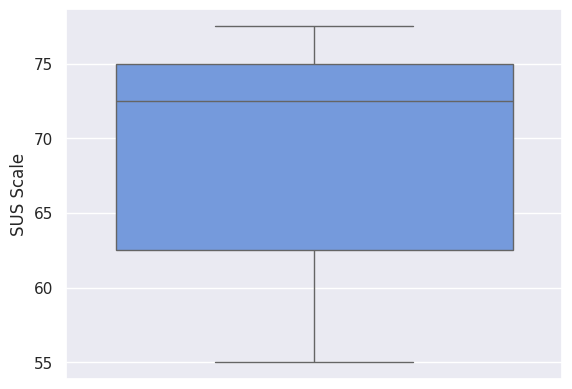

In [16]:
# Mapping for positively scored SUS items
# Higher agreement corresponds to higher scores
sus_response_map_positive = {
    "Trifft gar nicht zu": 0,
    "Trifft eher nicht zu": 1,
    "Teils / Teils": 2,
    "Trifft eher zu": 3,
    "Trifft vollständig zu": 4                                                     
}

# Mapping for negatively scored SUS items
# Reverse-coded: Higher agreement corresponds to lower scores
sus_response_map_negative = {
    "Trifft gar nicht zu": 4,
    "Trifft eher nicht zu": 3,
    "Teils / Teils": 2,
    "Trifft eher zu": 1,
    "Trifft vollständig zu": 0
}


# Define the SUS columns
sus_columns_positive = ["PC_SUS_01", "PC_SUS_03", "PC_SUS_05", "PC_SUS_07", "PC_SUS_09"]
sus_columns_negative = ["PC_SUS_02", "PC_SUS_04", "PC_SUS_08"] 

# Copy DataFrame for SUS transformations
sus_df = df.copy()

# Recode positive SUS items
for col in sus_columns_positive:
    sus_df[col] = sus_df[col].map(sus_response_map_positive)

# Recode negative SUS items
for col in sus_columns_negative:
    sus_df[col] = sus_df[col].map(sus_response_map_negative)

# Calculate the SUS scale as the sum of all SUS columns, multiplied by 2.5
sus_columns = sus_columns_positive + sus_columns_negative
sus_df["SUS_Scale"] = sus_df[sus_columns].sum(axis=1) * 2.5

# Calculate overall mean, sd of SUS_Scale
sus_overall_mean = sus_df["SUS_Scale"].mean()
sus_overall_sd = sus_df['SUS_Scale'].std()

# Calculate Cronbach's alpha for the SUS items using Pingouin
sus_items = sus_df[sus_columns]  # Only the columns used for the SUS scale
sus_alpha = pg.cronbach_alpha(data=sus_items)

# Display overall SUS_Scale mean, standard deviation and Cronbach's alpha
display(Markdown("### Mean of SUS Scale"))
display(Markdown(f"**Mean:** {round(sus_overall_mean, 2)}"))
display(Markdown(f"**Standard Deviation (SD):** {round(sus_overall_sd, 2)}"))
display(Markdown(f"**Cronbach's Alpha:** {round(sus_alpha[0], 2)}"))

# Calculate mean and SD of SUS_Scale grouped by 'Group'
sus_group_stats = sus_df.groupby('Group')['SUS_Scale'].agg(['mean', 'std']).reset_index()
sus_group_stats.columns = ['Group', 'Mean SUS Scale', 'SD SUS Scale']

# Display SUS_Scale group means, sd in a table
display(Markdown("### Mean & SD for SUS Scale by Group"))
display(sus_group_stats)

# Plot data
display(Markdown("### Distribution of SUS Scale Scores"))
ax = sns.boxplot(
    y=sus_df["SUS_Scale"],
    color="cornflowerblue"
)
ax.set_ylabel("SUS Scale")

## System Preference

Participants were asked which system they preferred: the one with pre-consent, the one without pre-consent, or they could choose options indicating indecisiveness or uncertainty. The majority of participants (14 out of 15) preferred the system with pre-consent.

In [17]:
# Calculate totals and percentages for "System_Preference"
system_preference_df = pd.DataFrame({
    "Total": df['System_Preference'].value_counts(),
    "Percentage (%)": df['System_Preference'].value_counts(normalize=True) * 100
}).round(2)

# Display the table
display(Markdown(f"### System Preference \n **Original Question**: {get_original_label('System_Preference')}"))
display(system_preference_df)

### System Preference 
 **Original Question**: Welches der beiden Systeme würden Sie bevorzugen? 

,Total,Percentage (%)
System_Preference,,
App mit Pre-Consent,14,93.33
App ohne Pre-Consent,1,6.67


## Pre-Consent Mechanism (Usability & Trust)  

Participants were asked to evaluate the pre-consent mechanism regarding its functionality and usability on a scale ranging from *"Very Good"* to *"Poor"*. All participants found the mechanism easy to use, with 5 rating it as *"Very Good"* and 10 as *"Good"*.  

Regarding trust, participants were asked to evaluate the pre-consent mechanism on a scale from *"Do Not Trust At All"* to *"Fully Trust"*. The results showed that 73.33% of participants expressed *"Somewhat Trust"*, while 26.67% expressed *"Fully Trust"*.  


In [18]:
# Pre-Consent Usability
# Calculate totals and percentages for "System_Preference"
preconsent_usability_df = pd.DataFrame({
    "Total": df['PreConsent_Usability'].value_counts(),
    "Percentage (%)": df['PreConsent_Usability'].value_counts(normalize=True) * 100
}).round(2)

# Display the table
display(Markdown(f"### Pre-Consent Usability \n **Original Question**: {get_original_label('PreConsent_Usability')}"))
display(preconsent_usability_df)

### Pre-Consent Usability 
 **Original Question**: Wie bewerten Sie den Pre-Consent-Mechanismus in Bezug auf seine Funktionalität und Benutzerfreundlichkeit?

,Total,Percentage (%)
PreConsent_Usability,,
Gut,10,66.67
Sehr gut,5,33.33


In [19]:
# Pre-Consent Trust
# Calculate totals and percentages for "PreConsent_Trust"
preconsent_trust_df = pd.DataFrame({
    "Total": df['PreConsent_Trust'].value_counts(),
    "Percentage (%)": df['PreConsent_Trust'].value_counts(normalize=True) * 100
}).round(2)

# Display the table
display(Markdown(f"### Pre-Consent Trust \n **Original Question**: {get_original_label('PreConsent_Trust')}"))
display(preconsent_trust_df)

### Pre-Consent Trust 
 **Original Question**: Inwieweit würden sie dem gezeigten Pre-Consent Mechanismus vertrauen?

,Total,Percentage (%)
PreConsent_Trust,,
Eher Vertrauen,11,73.33
Voll Vertrauen,4,26.67


## Inferenzstatistik

This section demonstrates the application of inferential statistical methods to the collected data. While these methods provide valuable insights into relationships and differences within larger datasets, it is important to note that the current sample size of 15 participants is too small to yield statistically meaningful or generalizable results. Consequently, the analysis presented here should be regarded as a demonstration of technique rather than an attempt to draw robust conclusions about the population.

To explore the data, we apply the following statistical tests:

- **Chi-Squared Test**: Used to analyze categorical data and evaluate whether there is a significant association between variables. In this case, it is applied to examine differences in categorical responses between system variants (e.g., with and without pre-consent).
  
- **Paired t-Test**: Used to compare the means of two related groups (e.g., the same participants' responses for the two system variants). This test evaluates whether the observed differences are statistically significant.

In [20]:
# Chi-Squared Test 01: Verifier and PreConsent Mechanism
chi2_verifier = pg.chi2_independence(
    data=df,                
    x="NoPC_Verifier",      
    y="PC_Verifier"         
)

# Display Results
display(Markdown("## Chi2-Test: Verifier and PreConsent Mechanism"))
display(Markdown("### Chi-Squared Test Results"))
display(chi2_verifier)


# Chi-Squared Test 02: Noticing Unexpected Transactions and PreConsent Mechanism
chi2_transaction = pg.chi2_independence(
    data=df,               
    x="NoPC_Transaction",   
    y="PC_Transaction"      
)

# Display Results
display(Markdown("## Chi2-Test: Noticing Unexpected Transactions and PreConsent Mechanism"))
display(Markdown("### Chi-Squared Test Results"))
display(chi2_transaction)

## Chi2-Test: Verifier and PreConsent Mechanism

### Chi-Squared Test Results

(PC_Verifier      Ja
 NoPC_Verifier      
 Ja             15.0,
 PC_Verifier    Ja
 NoPC_Verifier    
 Ja             15,
                  test    lambda  chi2  dof  pval  cramer  power
 0             pearson  1.000000   0.0  0.0   1.0     NaN    NaN
 1        cressie-read  0.666667   0.0  0.0   1.0     NaN    NaN
 2      log-likelihood  0.000000   0.0  0.0   1.0     NaN    NaN
 3       freeman-tukey -0.500000   0.0  0.0   1.0     NaN    NaN
 4  mod-log-likelihood -1.000000   0.0  0.0   1.0     NaN    NaN
 5              neyman -2.000000   0.0  0.0   1.0     NaN    NaN)

/home/simon/miniconda3/lib/python3.10/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/home/simon/miniconda3/lib/python3.10/site-packages/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/home/simon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7416: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/home/simon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7416: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/home/simon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7413: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


## Chi2-Test: Noticing Unexpected Transactions and PreConsent Mechanism

### Chi-Squared Test Results

(PC_Transaction          Ja      Nein  Weiß Nicht
 NoPC_Transaction                                
 Ja                8.666667  3.466667    0.866667
 Nein              1.333333  0.533333    0.133333,
 PC_Transaction    Ja  Nein  Weiß Nicht
 NoPC_Transaction                      
 Ja                10     2           1
 Nein               0     2           0,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  6.346154  2.0  0.041875  0.650444  0.609800
 1        cressie-read  0.666667  5.966242  2.0  0.050635  0.630674  0.581470
 2      log-likelihood  0.000000  6.235057  2.0  0.044266  0.644725  0.601652
 3       freeman-tukey -0.500000       NaN  2.0       NaN       NaN       NaN
 4  mod-log-likelihood -1.000000       inf  2.0  0.000000       inf       NaN
 5              neyman -2.000000       NaN  2.0       NaN       NaN       NaN)

In [21]:
# Define the response mapping
response_map = {
    "Stimmt gar nicht": 1,
    "Stimmt weitgehend nicht": 2,
    "Stimmt eher nicht": 3,
    "Stimmt eher": 4,
    "Stimmt weitgehend": 5,
    "Stimmt völlig": 6
}

# Copy the original DataFrame to a new DataFrame
ttest_df = df.copy()

# Apply the response mapping to all columns in the new DataFrame
for col in ttest_df.columns:
    ttest_df[col] = ttest_df[col].map(response_map)

# Drop rows with NaN values in relevant columns
columns_to_check = ['NoPC_01', 'PC_01', 'NoPC_02', 'PC_02', 'NoPC_03', 'PC_03', 'NoPC_04', 'PC_04', 'NoPC_05', 'PC_05']
ttest_df = ttest_df.dropna(subset=columns_to_check)

# Paired t-Test 01: Information Overload
question_01 = "Is the amount of information perceived as more overwhelming in the app without the PreConsent mechanism than in the app with the PreConsent mechanism?"
t_test_01 = pg.ttest(
    ttest_df['NoPC_01'], ttest_df['PC_01'],
    paired=True,
    alternative="less"
)
display(Markdown("## Paired t-Test 01: Information Overload"))
display(Markdown(f"**Question**: {question_01}"))
display(t_test_01)

# Paired t-Test 02: Clarity of Information
question_02 = "Does the perceived clarity of information differ between the app with the PreConsent mechanism and the app without it?"
t_test_02 = pg.ttest(
    ttest_df['NoPC_02'], ttest_df['PC_02'],
    paired=True,
    alternative="two-sided"
)
display(Markdown("## Paired t-Test 02: Clarity of Information"))
display(Markdown(f"**Question**: {question_02}"))
display(t_test_02)

# Paired t-Test 03: Repetition of Informed Consent
question_03 = "Is the repetition of informed consent perceived as less disruptive in the app with the PreConsent mechanism compared to the app without it?"
t_test_03 = pg.ttest(
    ttest_df['NoPC_03'], ttest_df['PC_03'],
    paired=True,
    alternative="greater"
)
display(Markdown("## Paired t-Test 03: Repetition of Informed Consent"))
display(Markdown(f"**Question**: {question_03}"))
display(t_test_03)

# Paired t-Test 04: Consent Process Length
question_04 = "I found the consent process per transaction too long."
t_test_04 = pg.ttest(
    ttest_df['NoPC_04'], ttest_df['PC_04'],
    paired=True,
    alternative="greater"
)
display(Markdown("## Paired t-Test 04: Consent Process Length"))
display(Markdown(f"**Question**: {question_04}"))
display(t_test_04)

# Paired t-Test 05: Task Concentration
question_05 = "Does the app without the PreConsent mechanism require more concentration to complete the task compared to the app with it?"
t_test_05 = pg.ttest(
    ttest_df['NoPC_05'], ttest_df['PC_05'],
    paired=True,
    alternative="greater"
)
display(Markdown("## Paired t-Test 05: Task Concentration"))
display(Markdown(f"**Question**: {question_05}"))
display(t_test_05)


## Paired t-Test 01: Information Overload

**Question**: Is the amount of information perceived as more overwhelming in the app without the PreConsent mechanism than in the app with the PreConsent mechanism?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.186154,14,less,0.572503,"[-inf, 0.7]",0.065887,0.533,0.029509


## Paired t-Test 02: Clarity of Information

**Question**: Does the perceived clarity of information differ between the app with the PreConsent mechanism and the app without it?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.806947,14,two-sided,0.433193,"[-0.22, 0.49]",0.234312,0.348,0.135254


## Paired t-Test 03: Repetition of Informed Consent

**Question**: Is the repetition of informed consent perceived as less disruptive in the app with the PreConsent mechanism compared to the app without it?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.003354,14,greater,0.004744,"[0.66, inf]",1.020716,11.632,0.982473


## Paired t-Test 04: Consent Process Length

**Question**: I found the consent process per transaction too long.

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.824855,14,greater,0.044715,"[0.03, inf]",0.601867,1.979,0.716106


## Paired t-Test 05: Task Concentration

**Question**: Does the app without the PreConsent mechanism require more concentration to complete the task compared to the app with it?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.744618,14,greater,0.234409,"[-0.36, inf]",0.184226,0.668,0.167161
